## Sistema de recomendación de películas



**Fuente de los datos:**

![Segment Local](https://www.themoviedb.org/assets/2/v4/logos/v2/blue_long_2-9665a76b1ae401a510ec1e0ca40ddcb3b0cfe45f1d51b77a308fea0845885648.svg "tmdb")

## Luces, Cámara...¡Acción! 🎥🍿

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.sparse import hstack

import warnings
warnings.filterwarnings('ignore')

from IPython.display import HTML

from pandas_profiling import ProfileReport

from functools import partial

from collections import Counter
import squarify

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from wordcloud import WordCloud
plt.style.use('fivethirtyeight')

from imageio import imread

In [2]:
movies = pd.read_csv('./movie_data1.csv')
credits = pd.read_csv('./movie_credits1.csv')

In [3]:
movies = movies.merge(credits, on='title')

In [4]:
## must be numeric columns: budget, popularity

movies['budget'] = movies['budget'].astype('float64')
movies['popularity'] = movies['popularity'].astype('float64')

In [5]:
## must be date columns

movies["release_date"] = pd.to_datetime(movies['release_date'])
movies['release_year'] = movies['release_date'].dt.year
movies['release_month'] = movies['release_date'].dt.month_name()
del movies["release_date"]

In [6]:
movies["profit"] = movies["revenue"] - movies["budget"]

In [7]:
## working with json columns

json_columns = ['cast', 'crew', 'genres', 'keywords', 'production_countries', 
                'production_companies', 'spoken_languages']

for x in json_columns:
    movies[x] = movies[x].apply(json.loads)
    if x != "crew":
        movies[x] = movies[x].apply(lambda row: [x["name"] for x in row])

In [8]:
def get_jobs(job, row):
    person_name = [x['name'] for x in row if x['job']==job] 
    return person_name[0] if len(person_name) else np.nan

movies["director"] = movies["crew"].apply(partial(get_jobs, "Director"))
movies["writer"]   = movies["crew"].apply(partial(get_jobs, "Writer"))
movies["producer"] = movies["crew"].apply(partial(get_jobs, "Producer"))
del movies["crew"]

In [9]:
for col in ["runtime", "release_year", "release_month"]:
    movies[col] = movies[col].fillna(movies[col].mode().iloc[0])

In [10]:
movies.drop('homepage', axis=1, inplace=True)

In [11]:
def show_ratings():
    fig,ax = plt.subplots(figsize=(8,4))
    sns.histplot(data=movies, x="vote_average", kde=True)
    ax.set(xlim=(1, 10))
    ax.set(title="Distribution of ratings");

### ¿Cómo están distribuidas las puntuaciones de las películas?

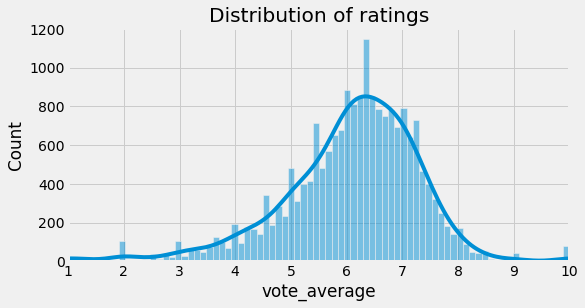

In [12]:
show_ratings()

### ¿Qué géneros abundan más?

In [13]:
## plot genre frequency (Drama looks to be the most popular genre followed by Comedy)

genres = sum(movies["genres"].values, [])
genres_info = Counter(genres)

In [14]:
def show_genres():
    plt.figure(figsize=(15, 10))
    plt.title("Genres", fontsize=25)
    squarify.plot(genres_info.values(), label=genres_info.keys(), text_kwargs={'fontsize':12}, bar_kwargs={'alpha':.7}, pad=True)
    plt.axis("off");

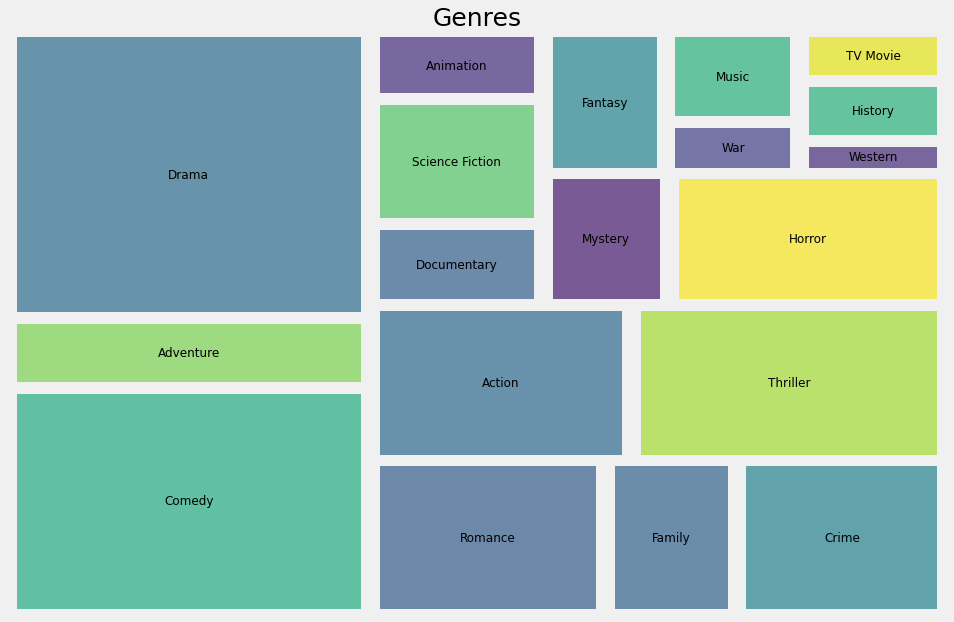

In [15]:
show_genres()

### Popularidad de palabras clave

In [16]:
top_keywords = 30
keywords = sum(movies["keywords"].values, [])
keywords_info = Counter(keywords)
top_keywords = dict(keywords_info.most_common(top_keywords))

In [17]:
reversed_keys = list(reversed(top_keywords.keys()))

In [18]:
reversed_values = list(reversed(top_keywords.values()))

In [19]:
def show_keywords():
    plt.figure(figsize=(25, 15))
    plt.barh(reversed_keys, reversed_values, align='center')
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlabel("No. of occurences", fontsize=35)
    plt.ylabel("Keywords", fontsize=35)
    plt.title("Keywords popularity", fontsize=40)
    plt.show()

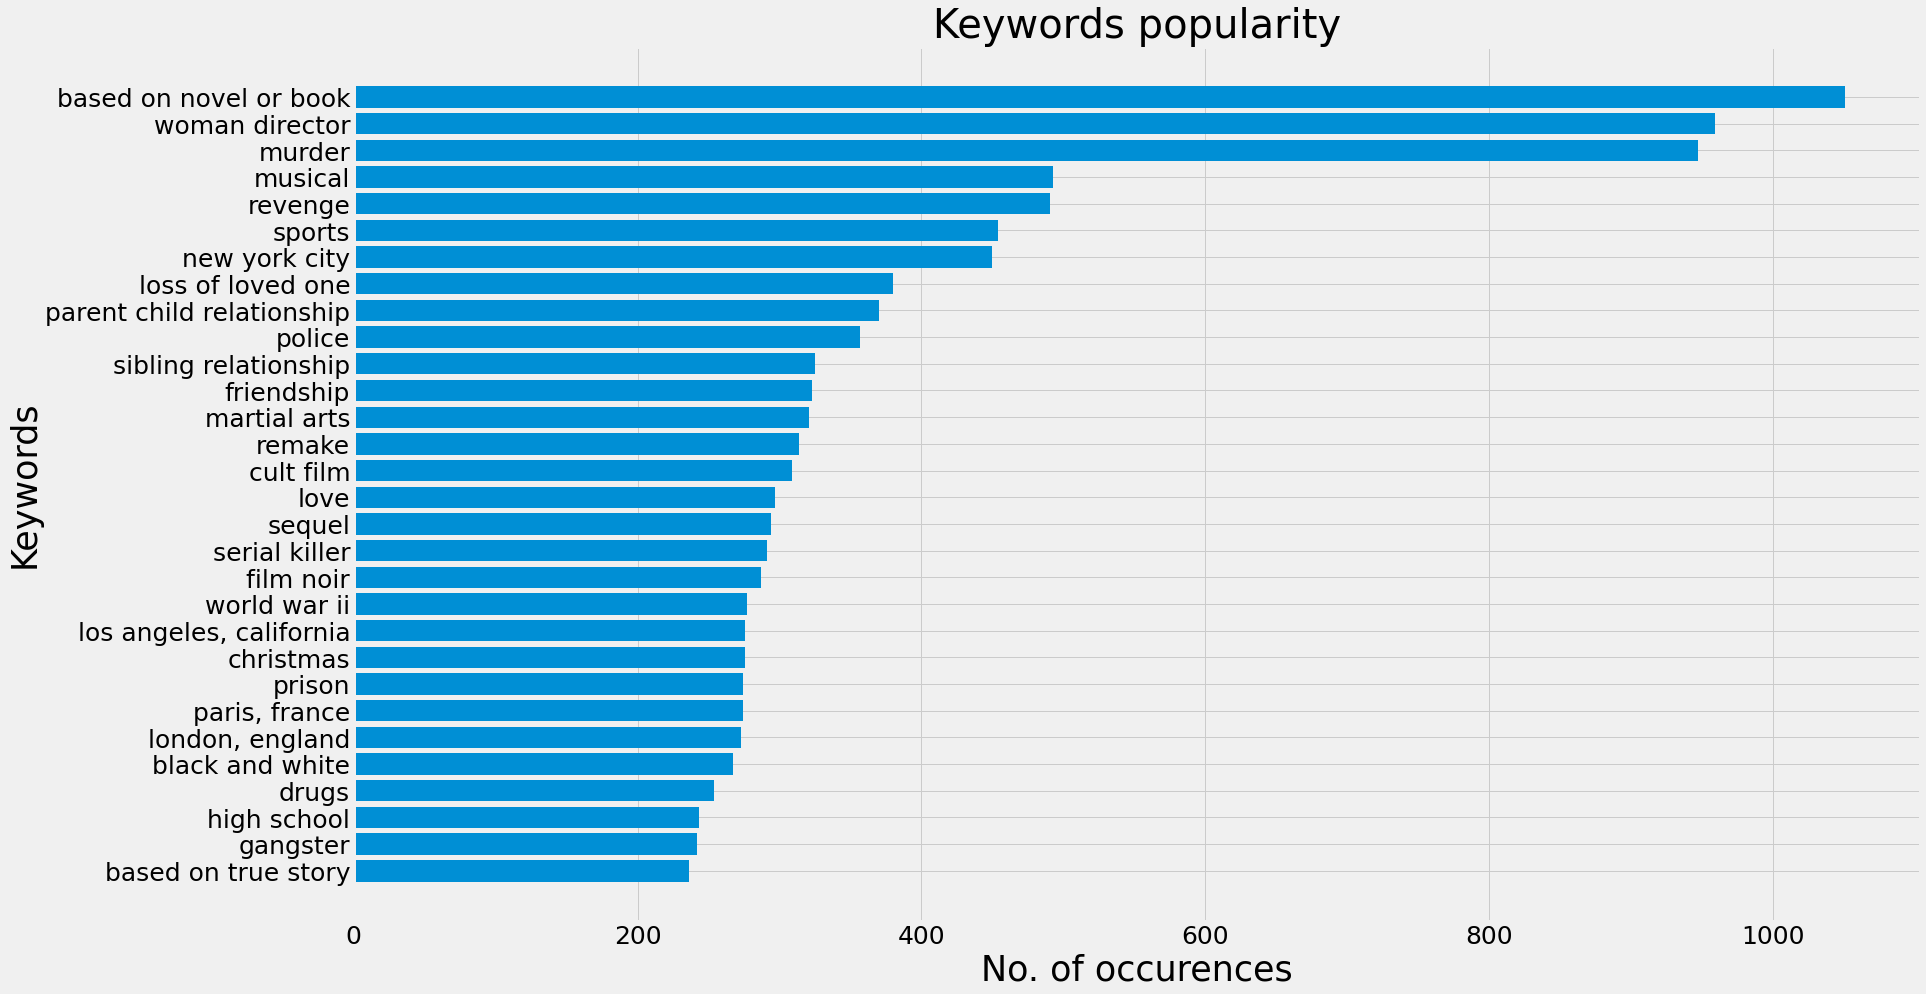

In [20]:
show_keywords()

### ¿Qué actores han aparecido en más películas?

In [21]:
cast = sum(movies["cast"].values, [])

In [22]:
cast_info = Counter(cast)
top_cast = dict(cast_info.most_common(30))

In [23]:
def show_actors():
    # plot unique cast frequency

    wordcloud = WordCloud(background_color='black', width=800, height=400)
    wordcloud.generate_from_frequencies(top_cast)

    plt.figure(figsize=(13,8))
    plt.title("Actors/actresses with highest appearance", fontsize=25)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off");

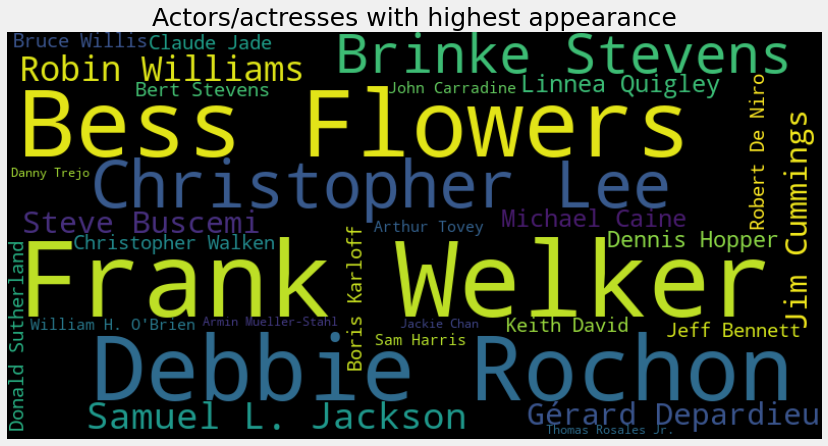

In [64]:
show_actors()

## Veamos nuestro primer modelo de recomendación basado únicamente en el título de la película

In [25]:
## Working with movies whose original language is in english (14,902 out out 20,701)

eng_movies = movies[movies['original_language'] == 'en'][['genres', 'overview', 'production_companies', 
                                                         'keywords', 'cast', 'title', 'director', 'writer', 'id']]

In [26]:
eng_movies = eng_movies.drop_duplicates(subset=['title'])

In [27]:
eng_movies = eng_movies.reset_index()

In [28]:
eng_movies.drop('index', axis=1, inplace=True)

In [29]:
eng_movies['overview'] = eng_movies['overview'].fillna('')
eng_movies['director'] = eng_movies['director'].fillna('')
eng_movies['writer'] = eng_movies['writer'].fillna('')

In [30]:
tfidf = TfidfVectorizer(stop_words='english')

In [31]:
tfidf_matrix = tfidf.fit_transform(eng_movies['title'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
indices = pd.Series(eng_movies.index, index=eng_movies['title'])

In [32]:
def get_recommendations(title, cosine_sim=cosine_sim):
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    movie_similarity = [i[1] for i in sim_scores]

    return pd.DataFrame(zip(eng_movies['title'].iloc[movie_indices], movie_similarity), columns=["title", "similarity"])

In [69]:
get_recommendations('Cars')

,title,similarity
0,Used Cars,0.671607
1,Riding in Cars with Boys,0.632985
2,Clarkson's Top 100 Cars,0.600957
3,Blondie,0.000000
4,New World Disorder 9: Never Enough,0.000000
5,Sesame Street: Elmo Loves You!,0.000000
6,Four Rooms,0.000000
7,Judgment Night,0.000000
8,Life in Loops (A Megacities RMX),0.000000
9,Star Wars,0.000000


### Vamos a eliminar los espacios para algunas columnas, ya que es mejor para nuestro sistema de recomendación distinguir entre "Johnny Depp" y "Johnny Knoxville", por ejemplo.

In [34]:
looking_john = eng_movies[eng_movies['cast'].str.join(',').str.contains('Johnny')]['cast']
lista_johnny = [name for x in looking_john for name in x if name.startswith('Johnny')]

In [35]:
len(set(lista_johnny))

178

In [36]:
johnnies = Counter(lista_johnny)
johnnies_count = dict(johnnies.most_common(5))

In [37]:
values = list(johnnies_count.values())

In [38]:
names = list(johnnies_count.keys())

In [39]:
def get_johnnies():
    # colors
    colors = ['#FF0011', '#add8e6', '#FFFF00', 
          '#ADFF2F', '#FFA500']
    # explosion
    explode = (0.05, 0.05, 0.05, 0.05, 0.05)

    plt.figure(figsize=(20,10))
  
    # Pie Chart
    plt.pie(values, colors=colors, labels=names,
            autopct='%1.1f%%', pctdistance=0.85,
            explode=explode)
  
    # draw circle
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
  
    # Adding Circle in Pie chart
    fig.gca().add_artist(centre_circle)
  
    # Adding Title of chart
    plt.title('Top 5 actors named Johnny')
  
    # Displaying Chart
    plt.show()

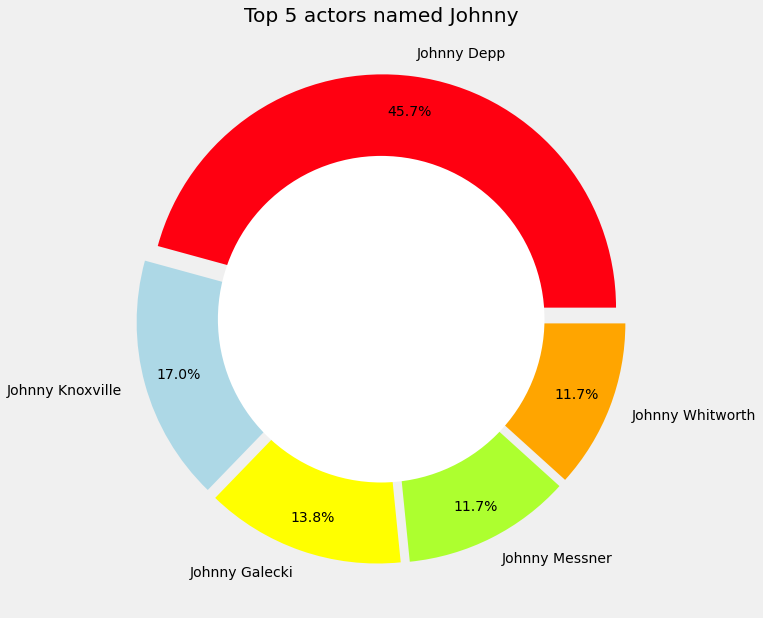

In [40]:
get_johnnies()

In [41]:
print(set(lista_johnny))

{'Johnny Erasme', 'Johnny Goar', 'Johnny McPhail', 'Johnny Silver', 'Johnny Faenza', 'Johnny Seven', 'Johnny Gimble', 'Johnny Gidcomb', "Johnny O'Donnell", 'Johnny Haymer', 'Johnny Vegas', 'Johnny Zander', 'Johnny Grady Jr.', 'Johnny Guarnieri', 'Johnny Miller', 'Johnny Britt', 'Johnny Dowd', 'Johnny Brown', 'Johnny Ashby', 'Johnny Meyer', 'Johnny Bamford', 'Johnny Palmiero', 'Johnny Morgan', 'Johnny Griffith', 'Johnny Martin', 'Johnny Strong', 'Johnny Rhodes', 'Johnny Thompson', 'Johnny Chan', 'Johnny Cheung Wa', 'Johnny Judkins', 'Johnny Yono', 'Johnny Weissmuller Jr.', 'Johnny McGovern', 'Johnny Cheah', 'Johnny Askwith', 'Johnny Contardo', 'Johnny Thomas III', 'Johnny Lee', 'Johnny Hagen', 'Johnny Thunders', 'Johnny Williams', 'Johnny Pruitt', 'Johnny Myers', "Johnny 'Sugarbear' Willis", 'Johnny Depp', 'Johnny Ahn', 'Johnny Kastl', 'Johnny Gilbert', 'Johnny Walsh', 'Johnny Unitas', 'Johnny Reno', 'Johnny Ramos', 'Johnny Hock', 'Johnny Egan', 'Johnny Barnes', 'Johnny Arthur', 'Johnny

In [42]:
## Get first 5 main actors

def get_4actors(x):
        return x[:5]

In [43]:
eng_movies['cast'] = eng_movies['cast'].apply(get_4actors)

In [44]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    elif isinstance(x, str):
        return str.lower(x.replace(" ", ""))
    else:
        return ''
    
features = ['genres', "production_companies", 'cast', 'director', "writer"]

for feature in features:
    eng_movies[feature] = eng_movies[feature].apply(clean_data)

In [45]:
eng_movies['keywords'] = eng_movies['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [46]:
features = ['genres', "production_companies", "keywords", 'cast', 'director', "writer"]

In [47]:
def join_features(x):
     return ' '.join([' '.join(x[f]) if isinstance(x[f], list) else str(x[f]) for f in features])
                     
eng_movies["join_features"] = eng_movies.apply(join_features, axis=1)

In [48]:
eng_movies['join_features'] = eng_movies['join_features'].str.strip()

In [49]:
eng_movies['model_title'] = eng_movies['title'].str.lower()

In [50]:
eng_movies['join_features'] = eng_movies['model_title'] + ' ' + eng_movies['join_features']

In [51]:
count = TfidfVectorizer(stop_words='english')
count_matrix = count.fit_transform(eng_movies['join_features'])
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
indices = pd.Series(eng_movies.index, index=eng_movies['title'])

count_matrix.shape

(13218, 62036)

### Veamos qué sucede al agregarle más características de una película a nuestro modelo 🤩

In [70]:
get_recommendations("Cars", cosine_sim2)

,title,similarity
0,Mater and the Ghostlight,0.385431
1,Tokyo Mater,0.262881
2,Red's Dream,0.259508
3,Luxo Jr.,0.225568
4,Knick Knack,0.223600
5,Tin Toy,0.211729
6,A Bug's Life,0.169647
7,Toy Story 2,0.156641
8,WALL·E,0.148514
9,Mike's New Car,0.142561


In [71]:
eng_movies[eng_movies['title'] == "Cars"]

,genres,overview,production_companies,keywords,cast,title,director,writer,id,join_features,model_title
565,"[animation, adventure, comedy, family]","Lightning McQueen, a hotshot rookie race car d...","[waltdisneypictures, pixar]","[carrace, success, route66, porsche, retiremen...","[owenwilson, larrythecableguy, bonniehunt, pau...",Cars,johnlasseter,,920,cars animation adventure comedy family waltdis...,cars


In [72]:
eng_movies[eng_movies['title'] == "Used Cars"]

,genres,overview,production_companies,keywords,cast,title,director,writer,id,join_features,model_title
5742,[comedy],When the owner of a struggling used car lot is...,[columbiapictures],"[senate, fight, arizona, salesman, carsalesman...","[kurtrussell, jackwarden, gerritgraham, frankm...",Used Cars,robertzemeckis,robertzemeckis,14475,used cars comedy columbiapictures senate fight...,used cars


In [73]:
eng_movies[eng_movies['title'] == "Mater and the Ghostlight"]

,genres,overview,production_companies,keywords,cast,title,director,writer,id,join_features,model_title
5430,"[animation, family]","Mater, the rusty but trusty tow truck from Car...",[pixar],"[towtruck, ghost, shortfilm]","[larrythecableguy, owenwilson, bonniehunt, pau...",Mater and the Ghostlight,johnlasseter,,13934,mater and the ghostlight animation family pixa...,mater and the ghostlight


In [79]:
print(eng_movies['cast'][565]) # Cars

['owenwilson', 'larrythecableguy', 'bonniehunt', 'paulnewman', 'tonyshalhoub']


In [80]:
print(eng_movies['cast'][5742]) # Used Cars

['kurtrussell', 'jackwarden', 'gerritgraham', 'frankmcrae', 'deborahharmon']


In [81]:
print(eng_movies['cast'][5430]) # Batman Begins

['larrythecableguy', 'owenwilson', 'bonniehunt', 'paulnewman', 'michaelwallis']


## Predictor de puntuación

In [60]:
corrs = movies.corr()['vote_average'].sort_values(ascending=False).reset_index()[1:-1]
corrs.columns = ['Features', 'Correlation with Rating']

In [61]:
corrs

,Features,Correlation with Rating
1,runtime,0.319612
2,vote_count,0.200726
3,popularity,0.186048
4,revenue,0.132173
5,profit,0.121352
6,budget,0.119947
7,release_year,-0.123968


### Estas 10 películas nos ayudarán ahora a predecir la puntuación de nuestra película seleccionada, siendo esta el promedio de las puntuaciones de las películas similares.

In [62]:
# These 10 movies will now help in predicting the score for our selected movie. 
# For this, I'm going to take the average of the scores of the similar movies 
# and find the score for the desired movie.

In [82]:
def get_recoms_and_score(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    movie_similarity = [i[1] for i in sim_scores]
    sims = pd.DataFrame(zip(eng_movies['title'].iloc[movie_indices], movie_similarity), columns=["title", "similarity"])
    
    counter = 0
    lista_scores = []

    for i in range(10):
        score = movies[movies['title'] == sims['title'].values[counter]]['vote_average'].values[0]
        counter+=1
        lista_scores.append(score)
    
    pred_score = np.mean(lista_scores)
    
    real_score = movies[movies['title'] == title]['vote_average'].values[0]
    
    print(f'The predicted rating for {title} is: {pred_score}')
    print('')
    print(f'The real rating for {title} is: {real_score}')
    print('')
    
    print("\nRecommended movies: ")
    print('')
    return sims.set_index('title')

In [83]:
get_recoms_and_score('Cars', cosine_sim2)

The predicted rating for Cars is: 6.841800000000001

The real rating for Cars is: 6.9


Recommended movies: 



,similarity
title,
Mater and the Ghostlight,0.385431
Tokyo Mater,0.262881
Red's Dream,0.259508
Luxo Jr.,0.225568
Knick Knack,0.223600
Tin Toy,0.211729
A Bug's Life,0.169647
Toy Story 2,0.156641
WALL·E,0.148514
